---
title: "9. Model Comparison"
author: "Jordan Chong"
date: "2024-02-22"
format:
  html:
    theme: lux          # A clean, professional quantitative theme
    toc: true           # Adds a table of contents on the right
    toc-depth: 3
    number-sections: true
    code-fold: show     # Allows viewers to collapse/expand your Python code!
    code-tools: true
    df-print: paged     # Makes pandas DataFrames look beautiful
execute:
  warning: false        # Hides Python warnings from the final HTML
  echo: true            # Shows your code (crucial for a portfolio)
---

## Setup: Importing and Defining the State

In [4]:
import numpy as np
import warnings
import matplotlib.pyplot as plt

# 1. Import your custom engine tools
from data_loader import MarketDataLoader
from quant_math_engine import bs_call_price, merton_jump_call, heston_call_price, bates_call_price, implied_volatility

# 2. Load Data 
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

# 3. Calculate Real Market IVs for the scatter plot
target_ivs, valid_strikes = [], []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs) * 100 # Convert to percentage

print(f"✅ Market Data Loaded: {len(valid_strikes)} strikes ready for comparison.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Market Data Loaded: 352 strikes ready for comparison.


In [7]:
print("Loading Calibrated Parameters...")

# 1. Black-Scholes (From Notebook 04)
bs_sigma = 0.1245  

# 2. Merton Jump Diffusion (From Notebook 05)
merton_params = {
    'sigma': 0.0850, 
    'lam': 0.9923, 
    'mu_j': -0.0825, 
    'delta': 0.0779
}

# 3. Heston Stochastic Volatility (From Notebook 06)
heston_params = {
    'v0': 0.0115, 
    'kappa': 3.0293, 
    'theta': 0.0684, 
    'xi': 1.1963, 
    'rho': -0.6572
}

# 4. Bates SVJ Model (The Ultimate Combination)
# 4. Bates SVJ Model (The Ultimate Combination)
bates_params = {
    'v0': 0.0135, 
    'kappa': 3.0290, 
    'theta': 0.0530, 
    'xi': 1.1920, 
    'rho': -0.6481,
    'lam': 0.9871,
    'mu_j': 0.0,
    'delta': 0.0187
}

print("✅ Parameters successfully loaded into memory.")

Loading Calibrated Parameters...
✅ Parameters successfully loaded into memory.


## Calibration of the Bates Model

In [8]:
def bates_objective(params):
    v0, kappa, theta, xi, rho, lam, mu_j, delta = params
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            m_price = bates_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# Parameter Seeding: [v0, kappa, theta, xi, rho, lam, mu_j, delta]
# We start exactly where Heston and Merton left off!
bates_guess = [0.0115, 3.0293, 0.0684, 1.1963, -0.6572, 0.9923, -0.0825, 0.0779]

bates_bounds = [
    (0.005, 0.15), (0.5, 5.0), (0.005, 0.15), (0.05, 1.5), (-0.95, -0.2), # Heston bounds
    (0.0, 3.0), (-0.5, 0.0), (0.01, 0.3)                                  # Merton bounds
]

print("Optimizing Bates Parameters (Seeded Fast Search)...")
start_time = time.time()
res_bates = minimize(bates_objective, bates_guess, method='L-BFGS-B', bounds=bates_bounds)

print(f"✅ Finished in {round(time.time() - start_time, 2)}s")
print(f"Optimal Parameters: {res_bates.x}")
print(f"Mean Squared Error: {res_bates.fun:.6f}")

Optimizing Bates Parameters (Seeded Fast Search)...


KeyboardInterrupt: 

## Visualising the Model against Live Data

Generating Bates Volatility Smile...


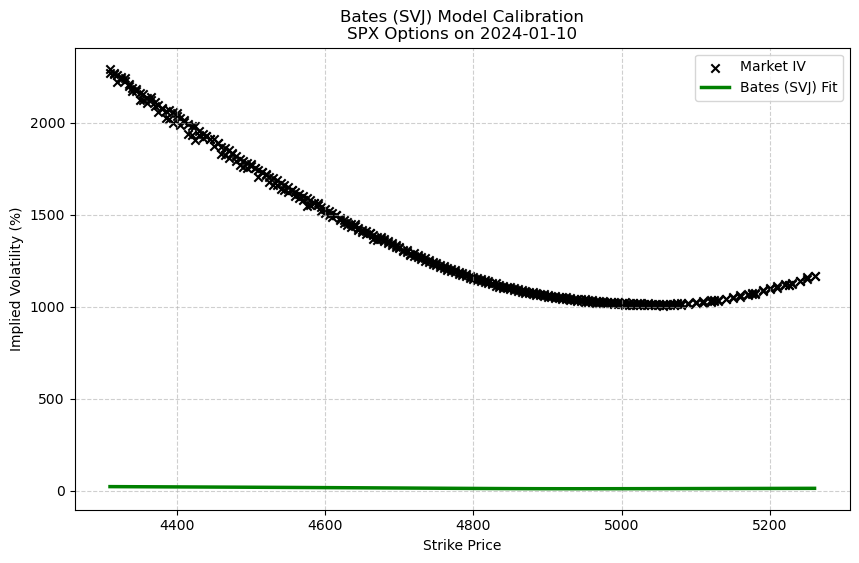

In [9]:
print("Generating Bates Volatility Smile...")

smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
bates_prices = [bates_call_price(S0, k, T, r, q, *res_bates.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bates_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(bates_prices, smooth_strikes)]

valid_idx = ~np.isnan(bates_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(bates_iv)[valid_idx] * 100

plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')
plt.plot(clean_strikes, clean_iv, color='green', label='Bates (SVJ) Fit', linewidth=2.5)

plt.title(f"Bates (SVJ) Model Calibration\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Generating Theoretical Option Prices and Implied Volatilities...
✅ Math complete. Rendering Master Plot...


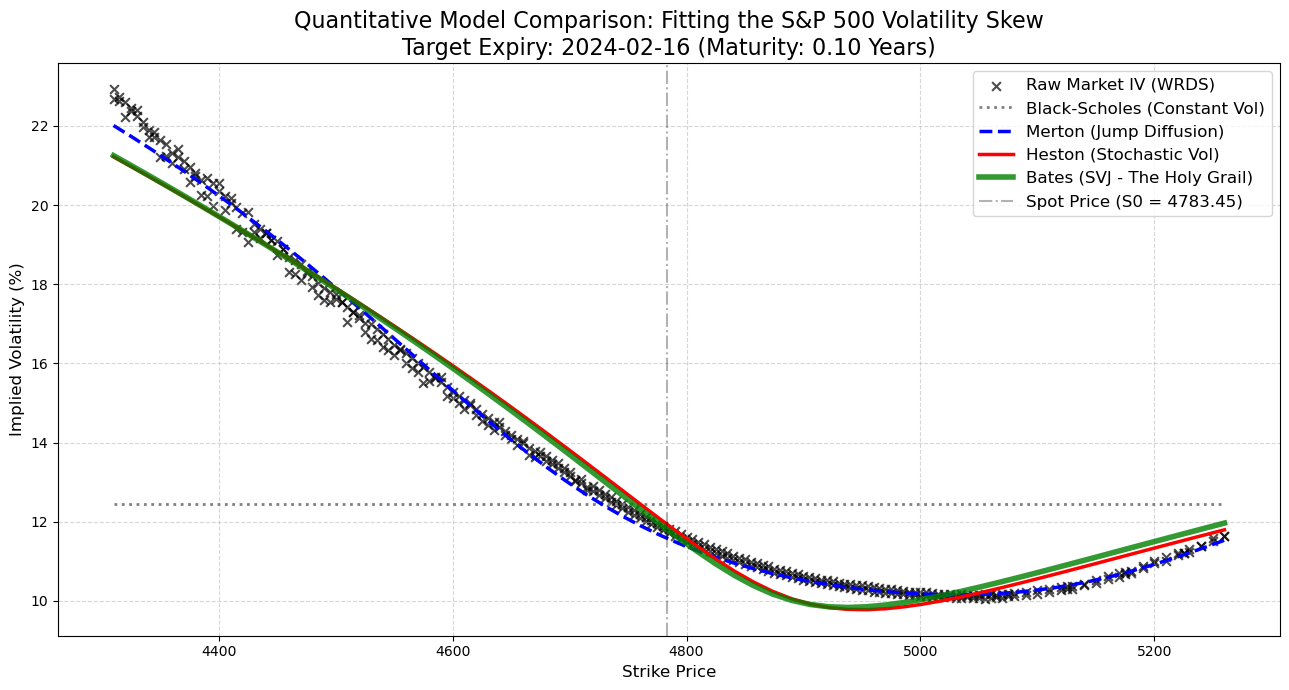

In [10]:
print("Generating Theoretical Option Prices and Implied Volatilities...")

# Create a perfectly smooth x-axis for drawing the lines
smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 60)

# Arrays to hold the y-axis values
bs_iv_line = np.full_like(smooth_strikes, bs_sigma) * 100
merton_ivs, heston_ivs, bates_ivs = [], [], []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for K in smooth_strikes:
        # Merton Math
        p_merton = merton_jump_call(S0, K, T, r, q, **merton_params)
        merton_ivs.append(implied_volatility(p_merton, S0, K, T, r, q) * 100)
        
        # Heston Math
        p_heston = heston_call_price(S0, K, T, r, q, **heston_params)
        heston_ivs.append(implied_volatility(p_heston, S0, K, T, r, q) * 100)
        
        # Bates Math
        p_bates = bates_call_price(S0, K, T, r, q, **bates_params)
        bates_ivs.append(implied_volatility(p_bates, S0, K, T, r, q) * 100)

print("✅ Math complete. Rendering Master Plot...")

# --- THE MASTER PLOT ---
plt.figure(figsize=(13, 7))

# 1. The Real Market Reality
plt.scatter(valid_strikes, target_ivs, color='black', label='Raw Market IV (WRDS)', marker='x', alpha=0.7, s=40)

# 2. The Theoretical Models
plt.plot(smooth_strikes, bs_iv_line, color='gray', label='Black-Scholes (Constant Vol)', linewidth=2, linestyle=':')
plt.plot(smooth_strikes, merton_ivs, color='blue', label='Merton (Jump Diffusion)', linewidth=2.5, linestyle='--')
plt.plot(smooth_strikes, heston_ivs, color='red', label='Heston (Stochastic Vol)', linewidth=2.5)
plt.plot(smooth_strikes, bates_ivs, color='green', label='Bates (SVJ - The Holy Grail)', linewidth=4, alpha=0.8)

# Formatting
plt.axvline(S0, color='black', linestyle='-.', alpha=0.3, label=f'Spot Price (S0 = {S0})')
plt.title(f"Quantitative Model Comparison: Fitting the S&P 500 Volatility Skew\nTarget Expiry: {TARGET_EXDATE} (Maturity: {T:.2f} Years)", fontsize=16)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()